In [1]:
import haversine as hs
from haversine import Unit
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import re
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import covariance
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings('ignore')

Load matrix with sites information

In [3]:
df_info = pd.read_excel(r'/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Matrices_input/Matrix_information.xlsx')
df_info

,Point,latitude,longitude,Habitat,Site,Recording Name
0,KLSA01,7.36574,-73.85669,1,0,SMA03286
1,KLSA02,7.36832,-73.86041,1,1,SMA03294
2,KLSA03,7.36765,-73.85181,2,2,SMA03332
3,KLSA04,7.36233,-73.85412,1,3,SMA03322
4,KLSA05,7.36389,-73.86101,3,4,SMA03210
5,KLSA06,7.36238,-73.84993,1,5,SMA03328
6,KLSA07,7.35796,-73.85642,3,6,SMA03297
7,KLSA08,7.36733,-73.86392,1,7,SMA03175ICP
8,KLSA09,7.35986,-73.86059,1,8,SMA03247
9,KLSA10,7.36400,-73.87019,2,9,SMA03327


In [5]:
# Function to plot nodes in the geographical position
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [11]:
def plot_network(matrix, threshold, same_position_data_func, df_info):
    # Prepare the matrix for network illustration
    links = matrix.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links2 = matrix.stack().reset_index()
    links2.columns = ['var1', 'var2', 'value']

    links = links.loc[(abs(links['value']) >= threshold) & (links['var1'] != links['var2'])]
    links2 = links2.loc[(links2['var1'] != links2['var2'])]

    # Create graph
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', edge_attr='value', create_using=nx.Graph())

    all_nodes = pd.Series(pd.concat([links2['var1'], links2['var2']])).unique()

    # Create a complete graph with all nodes
    G_complete = nx.complete_graph(all_nodes)

    # Nodes position and colors
    coordinates = same_position_data_func(df_info)
    coordinates = coordinates[G_complete.nodes]
    colores = df_info.Habitat.values[G_complete.nodes]
    positions = dict(zip(G_complete.nodes, coordinates))

    # Edge weights
    edge_weights = [abs(G[u][v]['value']) for u, v in G.edges()]

    plt.figure(figsize=(15, 10))

    node_size = 1400
    node_color = colores
    node_border_color = 'white'
    node_border_width = 0
    node_labels = {node: node for node in G_complete.nodes()}
    nx.draw_networkx_nodes(G_complete, positions, nodelist=G_complete.nodes(), node_size=node_size, node_color=node_color,
                           linewidths=node_border_width, edgecolors=node_border_color, cmap="summer_r")
    nx.draw_networkx_labels(G_complete, positions, labels=node_labels, font_color='black')

    min_width = 1
    max_width = 5
    scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights]

    # Plot final graph
    nx.draw_networkx_edges(G, positions, width=scaled_widths, edge_color="darkblue", alpha=0.8)

    plt.show()
    return G, G_complete

1 0.02347456701929684
Time Slot 1


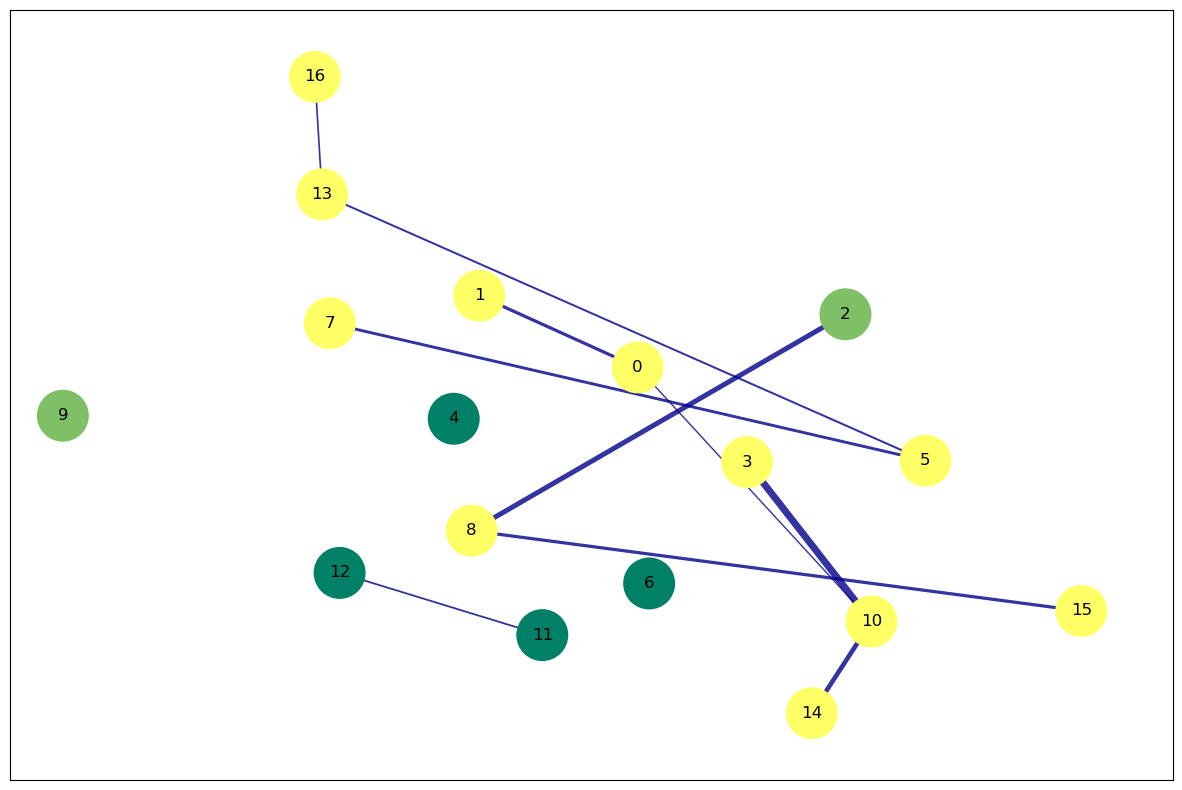

2 0.11097055416485317
Time Slot 2


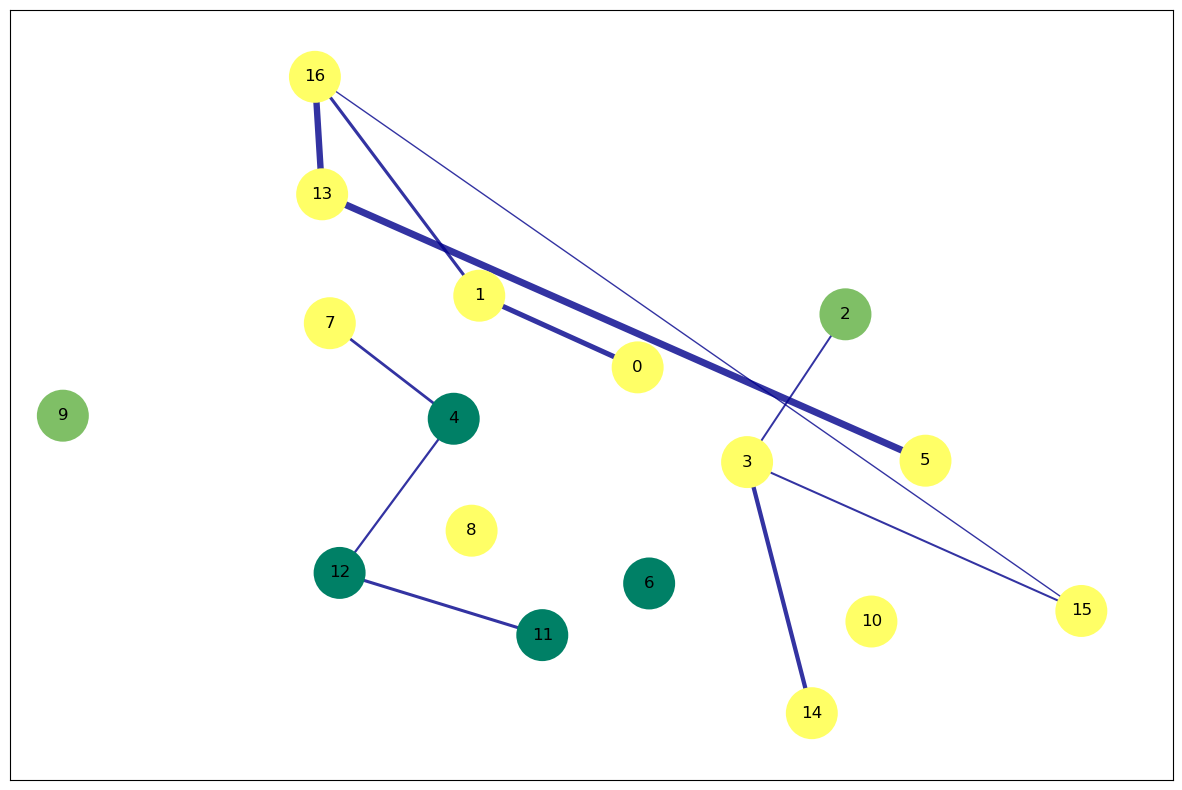

3 0.030130708384700344
Time Slot 3


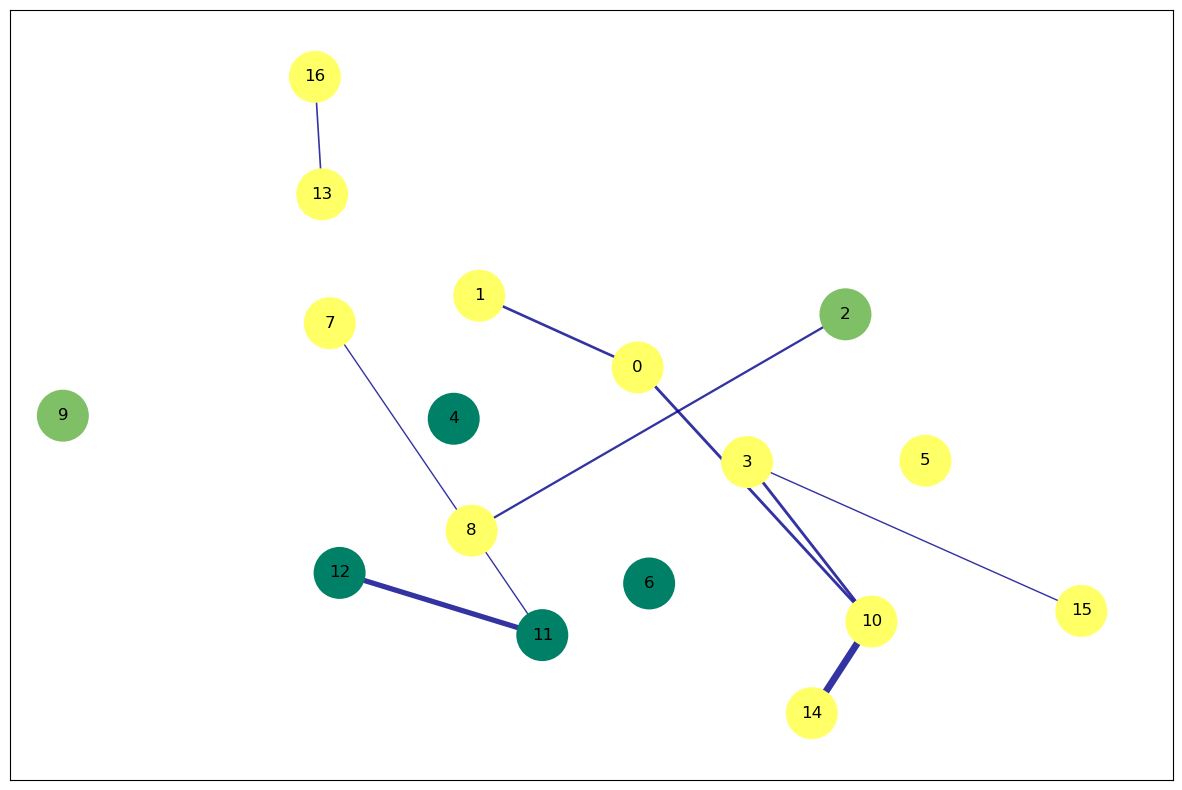

4 0.02746356733608903
Time Slot 4


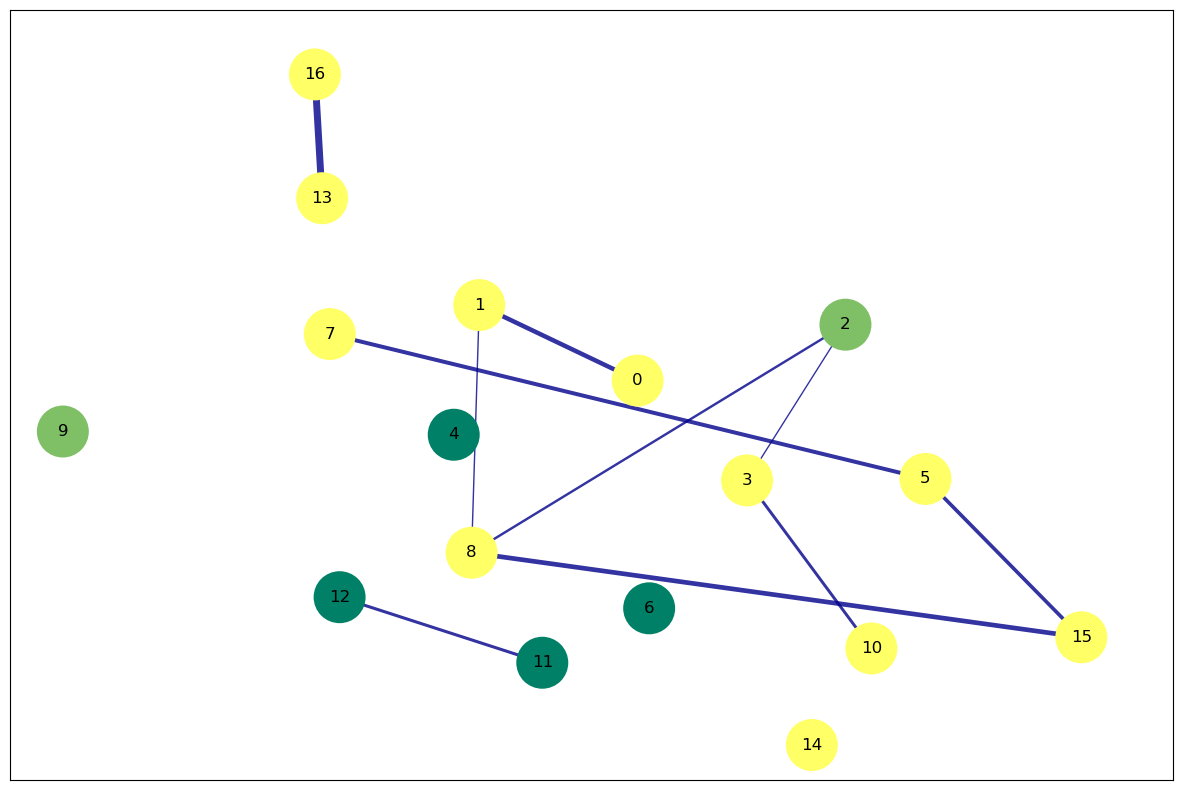

In [21]:
for i in range(1,5):
    df = pd.read_excel(r'/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Matrices_out/Analisis_horas/Matriz_f'+ str(i) +".xlsx")
    df_=df.iloc[:,1:]
    df_norm_all = (df_ - df_.min()) / (df_.max() - df_.min())
    df_norm_all.fillna(0, inplace=True)
    datos=np.array(df_norm_all)
    datos2=np.transpose(datos)
    datos2 /= datos2.std(axis=0)
    
    # Graphical Lasso
    edge_model = covariance.GraphicalLassoCV(cv=10, max_iter=1000,verbose=False, assume_centered=True)
    edge_model.fit(datos2)
    print(i, edge_model.alpha_)
    A= np.around(edge_model.covariance_, decimals=3) #covariance
    p = np.around(edge_model.precision_, decimals=3) # precision matrix
    p = pd.DataFrame(p)
  
    print('Time Slot',i)
    G, G_complete=plot_network(p, 0.3, same_posicion_data, df_info)
    